# Lake Victoria levels analysis : create interpolated lake level time series 1948-2022

## Data sources: 
- DAHITI, 2016 data used in Vanderkelen et al 2018
- DAHITI, 2021 April download 
- DAHITI, 2022 March download (this is what is used in paper)
- WMO Hydromet 1948-1995/1996 (from Vanderkelen et al 2018)

## What this notebook does: 
- analysis of DAHITI and WMO timeseries 
- looking at differences in DAHITI from different download periods 
- merge together the DH and HM timeseries 1949-2022
    - calculates average difference from overlapping dates
    - corrects HM to match DH
    - overwrites overlapping period with DH
    
## Output: 
- DAHITI lake levels 2022 txt file for use in MATLAB (DAHITI_lakelevels_070322.txt)
- lake level DH + HM (1948-2021) using DH 2021 data and overwriting DH on top of HM, raw (lakelevel_all_raw_DH21.csv)
- lake level DH + HM (1948-2022) using DH 2022 data and overwriting DH on top of HM, raw (lakelevel_all_raw_DH22.txt and csv) and interpolated to daily resolution (lakelevel_all_intr_DH22.txt and csv)

Created: July 2021 
By: Rosa Pietroiusti
Updated: 13 April 2022 (new 2022 dahiti data) 

environment: geo_env

In [1]:
# Import packages (geo_env)

# From Poorthius Geoprocessing 
import pandas as pd
import altair as alt
import altair_saver
from altair_saver import save

#from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from rasterstats import zonal_stats

# Others
import pprint
import os , glob
from osgeo import gdal
import scipy as scipy
from scipy import stats
import sklearn 
import datetime
from datetime import datetime
from matplotlib.pyplot import cm

alt.data_transformers.disable_max_rows()

# Today's date (last update)
now = datetime.now()
print (now.strftime("%Y-%m-%d %H:%M:%S"))

2022-08-11 10:43:47


In [2]:
# Figures path 

data_path = os.path.join("figures_apr22") #

if os.path.exists(data_path):
    print("The directory", data_path, "exists!")
else:
    os.makedirs(data_path)

The directory figures_apr22 exists!


In [3]:
# Increase resolution for saving figures

plt.rcParams['figure.dpi'] =  80
plt.rcParams['savefig.dpi'] = 300

## 1) Compare versions of DAHITI: 2022, 2021 (offline) and 2016 data 

### From Dahiti database, downloaded in April 2021 and March 2022, and from Inne's Github repository

In [4]:
# Read in data 

data_2021 = pd.read_csv('DAHITI_lakelevels_050421.csv') # downloaded April 2021, went offline for a while
data_2016_raw = pd.read_csv('DAHITI_lakelevels_Van.txt', sep = "\t",  header = None) # from Inne's thesis 
data_2022 = pd.read_csv('DAHITI_lakelevels_070322.csv') # downloaded March 2022

In [5]:
data_2022

,date,water level,error
0,1992-09-27,1135.000,0.000
1,1992-10-07,1135.023,0.001
2,1992-10-17,1135.032,0.000
3,1992-10-27,1134.958,0.000
4,1992-11-06,1135.035,0.000
...,...,...,...
1053,2022-01-22,1136.143,0.001
1054,2022-02-01,1136.145,0.001
1055,2022-02-11,1136.199,0.001
1056,2022-02-21,1136.227,0.001


### DAHITI April 2021 data

- *1992-09-27 to 2021-01-10*

In [6]:
data_2021['date'] = pd.to_datetime(data_2021['date'])
data_2021

,date,water level,error
0,1992-09-27,1134.974,0.001
1,1992-10-07,1134.990,0.001
2,1992-10-17,1135.013,0.001
3,1992-10-27,1134.945,0.001
4,1992-11-06,1135.004,0.001
...,...,...,...
1011,2020-12-02,1136.513,0.001
1012,2020-12-12,1136.568,0.001
1013,2020-12-22,1136.500,0.001
1014,2021-01-01,1136.549,0.001


In [7]:
data_2021.dtypes

date           datetime64[ns]
water level           float64
error                 float64
dtype: object

In [8]:
# Temporal resolution of DAHITI 2021 data 

dt = np.diff(data_2021['date'])
dt.mean() / np.timedelta64(1, "D")

10.17931034482758

(array([992.,   0.,   0.,  20.,   0.,   0.,   2.,   0.,   0.,   1.]),
 array([ 9. , 12.1, 15.2, 18.3, 21.4, 24.5, 27.6, 30.7, 33.8, 36.9, 40. ]),
 <BarContainer object of 10 artists>)

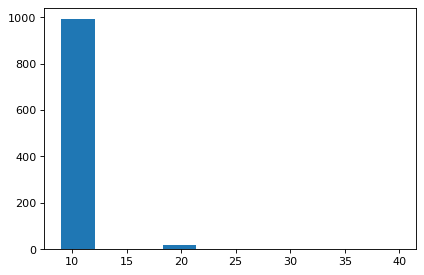

In [9]:
dt_hist = (dt / np.timedelta64(1, "D"))
dt_list = dt_hist.tolist()
plt.hist(dt_hist)

In [10]:
list(zip(*np.unique(dt_hist, return_counts=True))) 

[(9.0, 85),
 (10.0, 907),
 (19.0, 2),
 (20.0, 18),
 (29.0, 1),
 (30.0, 1),
 (40.0, 1)]

In [11]:
data_2021[['water level']].agg(['min', 'max', 'mean'])

,water level
min,1133.703000
max,1136.745000
mean,1135.030033


In [12]:
data_2021 = data_2021.set_index(['date'])
data_2021

,water level,error
date,,
1992-09-27,1134.974,0.001
1992-10-07,1134.990,0.001
1992-10-17,1135.013,0.001
1992-10-27,1134.945,0.001
1992-11-06,1135.004,0.001
...,...,...
2020-12-02,1136.513,0.001
2020-12-12,1136.568,0.001
2020-12-22,1136.500,0.001


### DAHITI March 2022 data
- *1992-09-27 to 2022-03-03*

In [13]:
data_2022['date'] = pd.to_datetime(data_2022['date'])
data_2022

,date,water level,error
0,1992-09-27,1135.000,0.000
1,1992-10-07,1135.023,0.001
2,1992-10-17,1135.032,0.000
3,1992-10-27,1134.958,0.000
4,1992-11-06,1135.035,0.000
...,...,...,...
1053,2022-01-22,1136.143,0.001
1054,2022-02-01,1136.145,0.001
1055,2022-02-11,1136.199,0.001
1056,2022-02-21,1136.227,0.001


10.169347209082304
[(9.0, 88), (10.0, 946), (19.0, 2), (20.0, 18), (29.0, 1), (30.0, 1), (40.0, 1)]


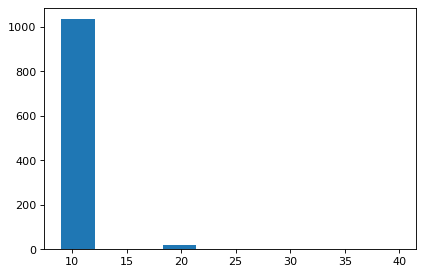

In [14]:
# Temporal resolution of DAHITI 2022 data 

dt = np.diff(data_2022['date'])
print(dt.mean() / np.timedelta64(1, "D"))

dt_hist = (dt / np.timedelta64(1, "D"))
dt_list = dt_hist.tolist()
plt.hist(dt_hist)

print(list(zip(*np.unique(dt_hist, return_counts=True))))

In [15]:
data_2022[['water level']].agg(['min', 'max', 'mean'])

,water level
min,1133.734000
max,1136.777000
mean,1135.111718


In [16]:
data_2022 = data_2022.set_index(['date'])
data_2022

,water level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [17]:
data_2022.dtypes

water level    float64
error          float64
dtype: object

In [18]:
# Save as a txt file for import to MATLAB WBM 

data_2022_export = data_2022.copy()
data_2022_export['day'] = data_2022.index.day
data_2022_export['month'] = data_2022.index.month
data_2022_export['year'] = data_2022.index.year
data_2022_export = data_2022_export[['year', 'month', 'day', 'water level', 'error']]
data_2022_export

,year,month,day,water level,error
date,,,,,
1992-09-27,1992,9,27,1135.000,0.000
1992-10-07,1992,10,7,1135.023,0.001
1992-10-17,1992,10,17,1135.032,0.000
1992-10-27,1992,10,27,1134.958,0.000
1992-11-06,1992,11,6,1135.035,0.000
...,...,...,...,...,...
2022-01-22,2022,1,22,1136.143,0.001
2022-02-01,2022,2,1,1136.145,0.001
2022-02-11,2022,2,11,1136.199,0.001


In [19]:
#data_2022_export.to_csv('data_modified/DAHITI_lakelevels_070322.txt', sep='\t', index=False, header=False)

### From Inne's thesis: DAHITI 2016 data

- *full data: 1992-09-27 to 2016-08-28* 
- *studied in thesis: '1993-1-1':'2014-12-31'*

In [20]:
data_2016_raw

,0,1,2,3,4
0,1992,9,27,1134.766,0.001
1,1992,10,7,1134.768,0.001
2,1992,10,17,1134.782,0.001
3,1992,10,27,1134.745,0.001
4,1992,11,6,1134.810,0.001
...,...,...,...,...,...
854,2016,7,19,1135.564,0.001
855,2016,7,29,1135.464,0.001
856,2016,8,8,1135.418,0.001
857,2016,8,18,1135.402,0.001


In [21]:
data_2016_raw.columns = ['year', 'month', 'day', 'water level', 'error']
data_2016_dates = pd.to_datetime(data_2016_raw[['year', 'month', 'day']])
df = pd.DataFrame(data_2016_dates, columns = ['date'])
df[['water level', 'error']] = data_2016_raw[['water level', 'error']]
data_2016 = df.set_index(['date'])
data_2016

,water level,error
date,,
1992-09-27,1134.766,0.001
1992-10-07,1134.768,0.001
1992-10-17,1134.782,0.001
1992-10-27,1134.745,0.001
1992-11-06,1134.810,0.001
...,...,...
2016-07-19,1135.564,0.001
2016-07-29,1135.464,0.001
2016-08-08,1135.418,0.001


### Look at differences

,water level
min,-0.215000
max,0.352000
mean,0.195508


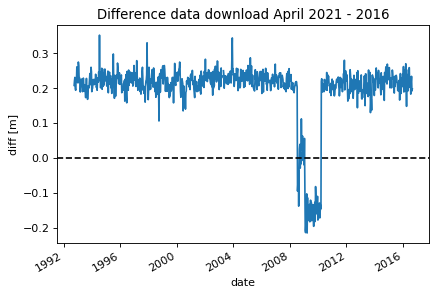

In [22]:
# Look at difference of overlapping period for 2016 and 2021 datasets

# total overlapping period loc['1992-09-27':'2016-08-28']
# period studied in Inne's thesis loc['1993-1-1':'2014-12-31']

diff_21_16 = data_2021.loc['1992-09-27':'2016-08-28'] - data_2016.loc['1992-09-27':'2016-08-28']

diff_21_16['water level'].plot(title = "Difference data download April 2021 - 2016")
plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.ylabel("diff [m]")
data = diff_21_16['water level']
#min_ylim, max_ylim = ax.get_ylim()
#plt.text(0.43, 0, 'Mean: {:.2f} m'.format(data.mean()), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

diff_21_16[['water level']].agg(['min', 'max', 'mean'])

,water level
min,-0.183000
max,0.415000
mean,0.224607


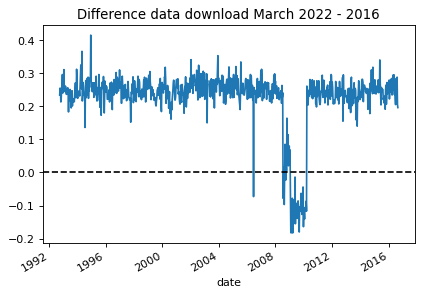

In [23]:
# Look at difference of overlapping period for 2016 and 2022 datasets

# total overlapping period loc['1992-09-27':'2016-08-28']
# period studied in Inne's thesis loc['1993-1-1':'2014-12-31']

diff_22_16 = data_2022.loc['1992-09-27':'2016-08-28'] - data_2016.loc['1992-09-27':'2016-08-28']

diff_22_16['water level'].plot(title = "Difference data download March 2022 - 2016")
plt.axhline(y = 0, color = 'k', linestyle = '--')

diff_22_16[['water level']].agg(['min', 'max', 'mean'])


,water level
min,-0.291000
max,0.194000
mean,0.029352


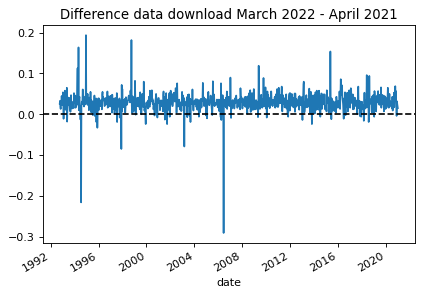

In [24]:
# Look at difference for April 2021 and March 2022 datasets

diff_21_22 = data_2022.loc['1992-09-27':'2021-01-10'] - data_2021.loc['1992-09-27':'2021-01-10']
diff_21_22['water level'].plot(title = "Difference data download March 2022 - April 2021")
plt.axhline(y = 0, color = 'k', linestyle = '--')

diff_21_22[['water level']].agg(['min', 'max', 'mean'])

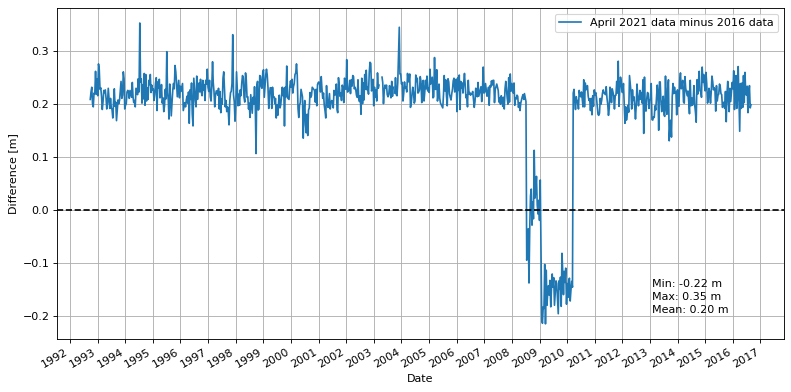

In [25]:
# Look at difference of overlapping period for 2016 and 2021 datasets

fig, ax = plt.subplots(figsize=(10, 5))
data = diff_21_16['water level']
data.plot(ax=ax, label="April 2021 data minus 2016 data")
ax.legend()
ax.grid(True)
plt.xlabel("Date")
plt.ylabel("Difference [m]")
plt.axhline(y = 0, color = 'k', linestyle = '--')
fig.tight_layout()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#Add summary stats
min_ylim, max_ylim = ax.get_ylim()
min_xlim, max_xlim = ax.get_xlim()
plt.text(max_xlim*0.9, min_ylim*0.6, 'Min: {:.2f} m'.format(data.min()))
plt.text(max_xlim*0.9, min_ylim*0.7, 'Max: {:.2f} m'.format(data.max()))
plt.text(max_xlim*0.9, min_ylim*0.8, 'Mean: {:.2f} m'.format(data.mean()))


#plt.show()
plt.savefig(os.path.join(data_path,'diffDAHITI_2021_2016.png'))


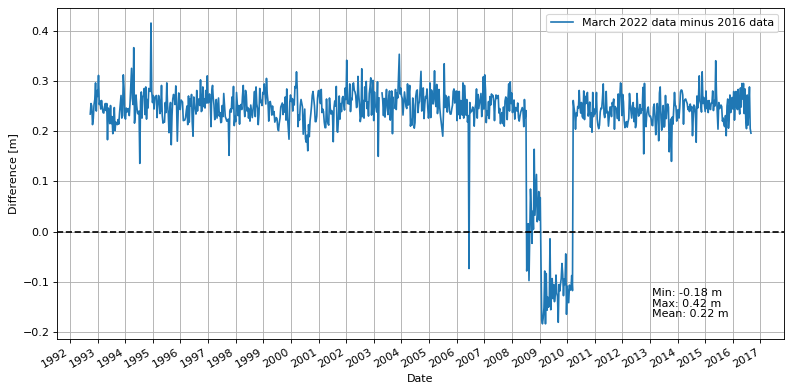

In [26]:
# Look at difference of overlapping period for 2016 and 2021 datasets

fig, ax = plt.subplots(figsize=(10, 5))
data = diff_22_16['water level']
data.plot(ax=ax, label="March 2022 data minus 2016 data")
ax.legend()
ax.grid(True)
plt.xlabel("Date")
plt.ylabel("Difference [m]")
plt.axhline(y = 0, color = 'k', linestyle = '--')
fig.tight_layout()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#Add summary stats
min_ylim, max_ylim = ax.get_ylim()
min_xlim, max_xlim = ax.get_xlim()
plt.text(max_xlim*0.9, min_ylim*0.6, 'Min: {:.2f} m'.format(data.min()))
plt.text(max_xlim*0.9, min_ylim*0.7, 'Max: {:.2f} m'.format(data.max()))
plt.text(max_xlim*0.9, min_ylim*0.8, 'Mean: {:.2f} m'.format(data.mean()))


plt.show()
#plt.savefig(os.path.join(data_path,'diffDAHITI_2022_2016.png'))

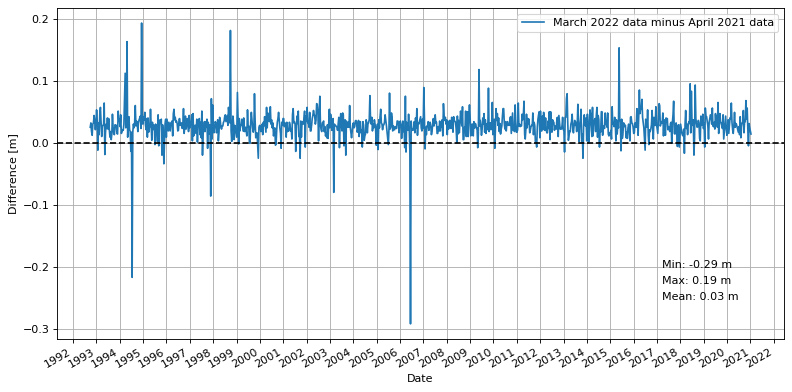

In [27]:
# Look at difference of overlapping period for 2016 and 2021 datasets

fig, ax = plt.subplots(figsize=(10, 5))
data = diff_21_22['water level']
data.plot(ax=ax, label="March 2022 data minus April 2021 data")
ax.legend()
ax.grid(True)
plt.xlabel("Date")
plt.ylabel("Difference [m]")
plt.axhline(y = 0, color = 'k', linestyle = '--')
fig.tight_layout()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#Add summary stats
min_ylim, max_ylim = ax.get_ylim()
min_xlim, max_xlim = ax.get_xlim()
plt.text(max_xlim*0.9, min_ylim*0.64, 'Min: {:.2f} m'.format(data.min()))
plt.text(max_xlim*0.9, min_ylim*0.72, 'Max: {:.2f} m'.format(data.max()))
plt.text(max_xlim*0.9, min_ylim*0.8, 'Mean: {:.2f} m'.format(data.mean()))


plt.show()
#plt.savefig(os.path.join(data_path,'diffDAHITI_2022_2021.png'))

In [28]:
# Restricted to Inne's thesis study period 

diff_1993_2014_v21 = data_2021.loc['1993-1-1':'2014-12-31'] - data_2016.loc['1993-1-1':'2014-12-31']
diff_1993_2014_v21

,water level,error
date,,
1993-01-04,0.215,0.0
1993-01-14,0.275,0.0
1993-01-24,0.264,0.0
1993-02-03,0.227,0.0
1993-02-13,0.230,0.0
...,...,...
2014-11-13,0.212,0.0
2014-11-22,0.269,0.0
2014-12-02,0.240,0.0


      water level
min     -0.215000
max      0.352000
mean     0.193408


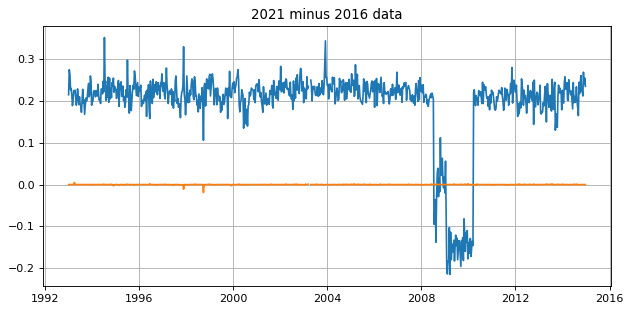

In [29]:
# DIFFERENCE in m between DAHITI 2016 and 2021 data only for Inne's study period
print(diff_1993_2014_v21[['water level']].agg(['min', 'max', 'mean']))

#Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(diff_1993_2014_v21)
ax.grid(True)
plt.title('2021 minus 2016 data')
fig.tight_layout()
plt.show()


In [30]:
# Plot the 2021 and 2016 data together 
data_2021_overlap = data_2021.loc['1992-09-27':'2016-08-28']
data_2016_overlap = data_2016.loc['1992-09-27':'2016-08-28']
data_2022_overlap = data_2022.loc['1992-09-27':'2016-08-28']


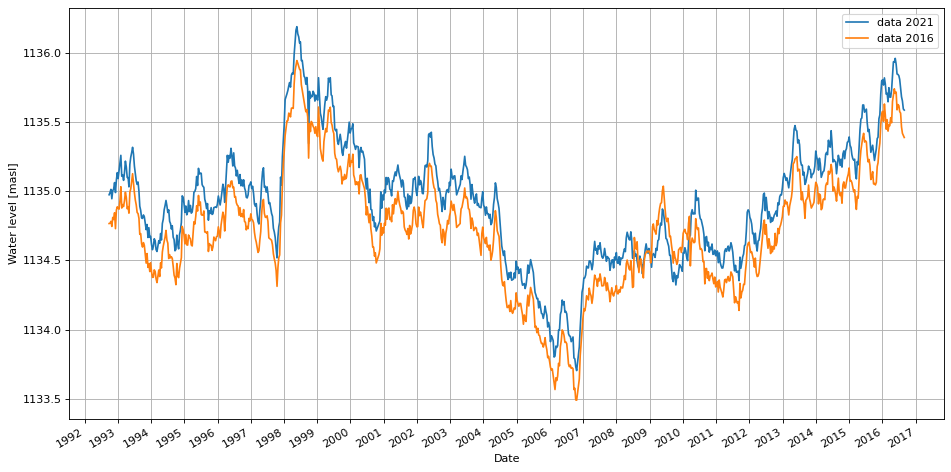

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
data_2021_overlap['water level'].plot(ax=ax, label="data 2021")
data_2016_overlap['water level'].plot(ax=ax, label="data 2016")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

#plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI_LakeVictoria_2021v2016.png'))

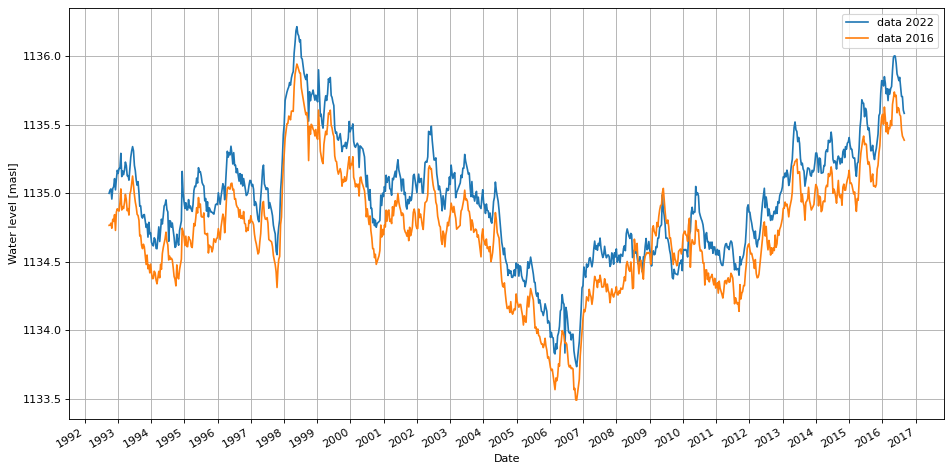

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
data_2022_overlap['water level'].plot(ax=ax, label="data 2022")
data_2016_overlap['water level'].plot(ax=ax, label="data 2016")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI_LakeVictoria_2022v2016.png'))

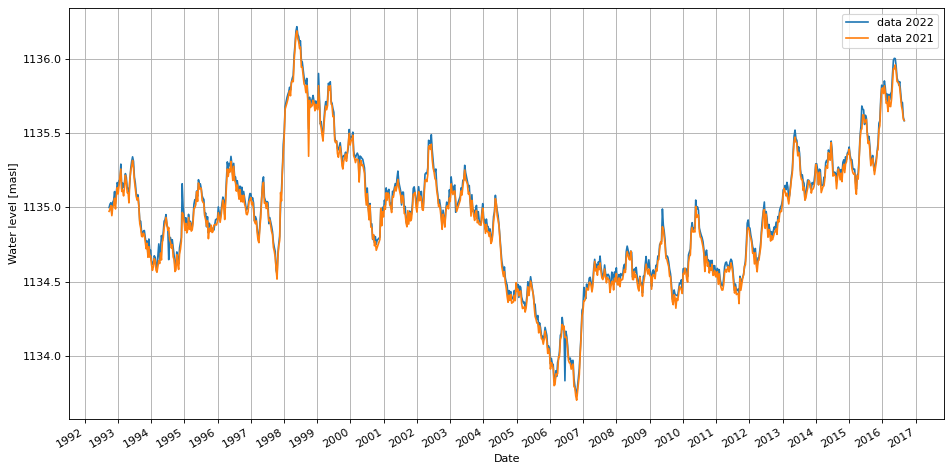

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
data_2022_overlap['water level'].plot(ax=ax, label="data 2022")
data_2021_overlap['water level'].plot(ax=ax, label="data 2021")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

#plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI_LakeVictoria_2022v2021.png'))

## 2) Do dL/dt and absolute level analysis - Compare analysis with 2021 and 2022 data

1. Plot DAHITI data 

Merge together HYDROMET and DAHITI data and calculate 

1. dL/dt vs. rank of 2020 event for different dt

2. Rolling average vs. rank of 2020 event for different averaging windows 

In [34]:
# Figures path 

#data_path = os.path.join("figures_3_apr22")

#if os.path.exists(data_path):
#    print("The directory", data_path, "exists!")
#else:
#    os.makedirs(data_path)

In [35]:
data_2022 # if you want april 2021 data use data_2021

,water level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [36]:
# Read in data - This is new version with 2022 data

DAHITI = data_2022.copy()
DAHITI=DAHITI.rename(columns={"water level": "water_level"})
DAHITI


,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [37]:
HYDROMET_raw = pd.read_csv('Jinja_lakelevels_Van.txt', sep = "\t",  header = None)
HYDROMET_raw

,0,1,2,3,4
0,1948,1,1,1134.097,11.210
1,1948,1,2,1134.102,11.215
2,1948,1,3,1134.062,11.175
3,1948,1,4,1134.052,11.165
4,1948,1,5,1134.077,11.190
...,...,...,...,...,...
17741,1996,7,28,1134.777,11.890
17742,1996,7,29,1134.757,11.870
17743,1996,7,30,1134.752,11.865
17744,1996,7,31,1134.717,11.830


In [38]:
HYDROMET_raw.columns = ['year', 'month', 'day', 'water level', 'meas']
HYDROMET_dates = pd.to_datetime(HYDROMET_raw[['year', 'month', 'day']])
df = pd.DataFrame(HYDROMET_dates, columns = ['date'])
df[['water_level', 'meas']] = HYDROMET_raw[['water level', 'meas']]
HYDROMET = df.set_index(['date'])
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [39]:
# Replace HYDROMET zeros with NaN, so that Matplotlib won't connect the points

HYDROMET.query('water_level == 0')

,water_level,meas
date,,
1977-01-01,0.0,0.0
1977-01-02,0.0,0.0
1977-01-03,0.0,0.0
1977-01-04,0.0,0.0
1977-01-05,0.0,0.0
...,...,...
1982-11-28,0.0,0.0
1982-11-29,0.0,0.0
1982-11-30,0.0,0.0


In [40]:
HYDROMET['water_level'] = HYDROMET['water_level'].replace(0, np.nan)
HYDROMET['meas'] = HYDROMET['meas'].replace(0, np.nan)
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [41]:
HYDROMET.query('water_level != water_level')

,water_level,meas
date,,
1977-01-01,NaN,NaN
1977-01-02,NaN,NaN
1977-01-03,NaN,NaN
1977-01-04,NaN,NaN
1977-01-05,NaN,NaN
...,...,...
1982-11-28,NaN,NaN
1982-11-29,NaN,NaN
1982-11-30,NaN,NaN


In [42]:
# Get summary stats 

DAHITI[['water_level']].agg(['min', 'max', 'mean']) 

,water_level
min,1133.734000
max,1136.777000
mean,1135.111718


In [43]:
HYDROMET[['water_level']].agg(['min', 'max', 'mean']) 

,water_level
min,1133.447000
max,1136.277000
mean,1134.686917


range= 3.04300000000012 mtrim= 1135.072125 mean= 1135.1117183364838 p10= 1134.4847 p90= 1135.8463


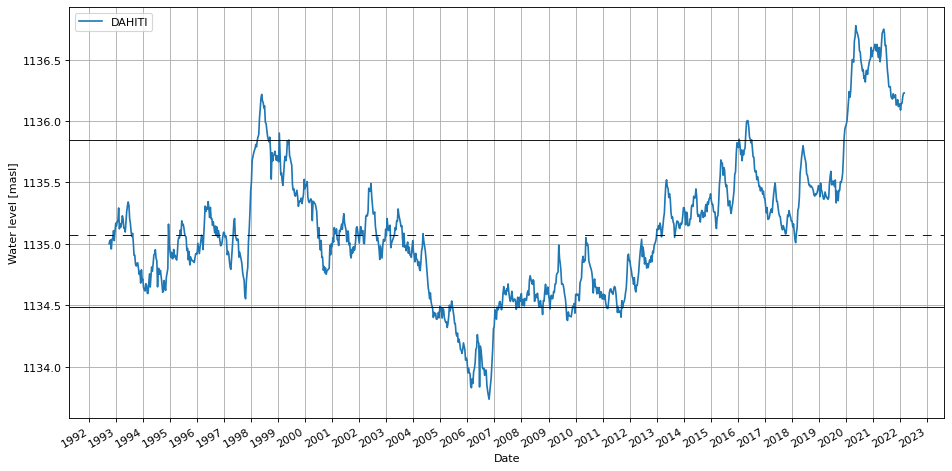

In [44]:
# Get mtrim for DAHITI and plot 

data = DAHITI
# range
max_level = data[['water_level']].max()
min_level = data[['water_level']].min()
range_level = max_level - min_level
# mtrim 
mtrim = stats.trim_mean(data[['water_level']], 0.1)
mtrim = mtrim.flatten().tolist()[0]
# 10th and 90th percentile
p10 = scipy.stats.scoreatpercentile(data[['water_level']], 10) # 10th percentile 
p90 = scipy.stats.scoreatpercentile(data[['water_level']], 90) # 90th percentile 

# print summary stats
print('range=',str(range_level[0]), 
      'mtrim=', str(mtrim), 'mean=', str(data[['water_level']].mean()[0]), 
      'p10=', str(p10), 'p90=',str(p90))

# plot 
fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
plt.axhline(mtrim, color='k', linewidth=0.8, linestyle='dashed', dashes=(10, 10))
plt.axhline(p10, color='k', linewidth=0.8)
plt.axhline(p90, color='k', linewidth=0.8)
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

#plt.savefig(os.path.join(data_path,'DAHITI_mtrim_DH22.png'))


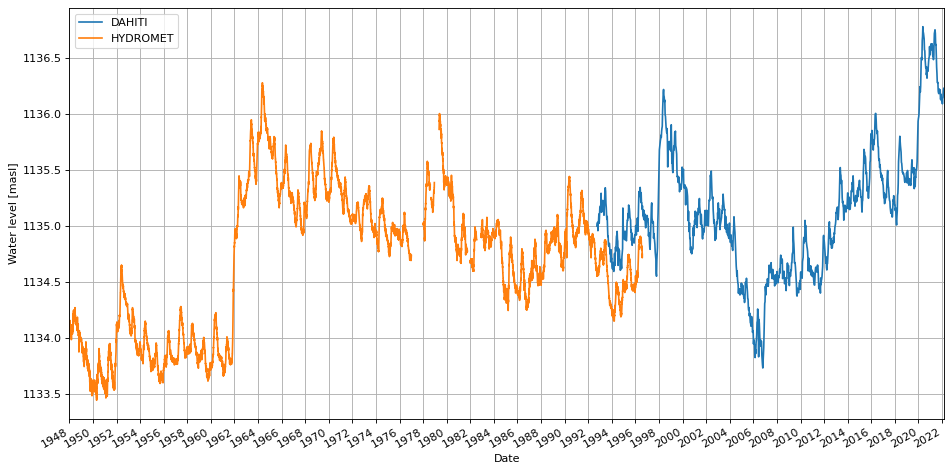

In [45]:
# Plot raw dahiti and hydromet

left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI_HYDROMET_raw_DH22_20220303.png'))

### Snap the two time-series together

In [46]:
DAHITI

,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [47]:
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [48]:
# Merge the two time-series, key on date, keep all observations (outer)
d_HYDROMET = HYDROMET.drop(['meas'], axis=1)
d_DAHITI = DAHITI.drop(['error'], axis=1)
df_merge = pd.merge(d_HYDROMET, d_DAHITI, how='outer', on='date')
df_merge.columns = ['HYDROMET', 'DAHITI']
df_merge # 18625 rows

# Get only the overlapping observations
df_overlap = df_merge.query('HYDROMET == HYDROMET & DAHITI == DAHITI')
df_overlap # 137 rows [1992-09-27 : 1996-07-26] 

,HYDROMET,DAHITI
date,,
1992-09-27,1134.567,1135.000
1992-10-07,1134.577,1135.023
1992-10-17,1134.567,1135.032
1992-10-27,1134.597,1134.958
1992-11-06,1134.582,1135.035
...,...,...
1996-06-17,1134.877,1135.214
1996-06-27,1134.872,1135.297
1996-07-07,1134.807,1135.204


In [49]:
avg_diff = (df_overlap['DAHITI'] - df_overlap['HYDROMET']).mean() # DAHITI overestimates vs. HYDROMET
n_diff = len(df_overlap)
std_diff = (df_overlap['DAHITI'] - df_overlap['HYDROMET']).std()
print('avg_diff =', avg_diff,  'n_diff =', n_diff, 'std_diff =', std_diff)
print('avg_diff_r =', round(avg_diff,3), 'std_diff_r =', round(std_diff,3) )
# 2021 data: Avg diff is 40.2 cm +/- 4.35 cm (one std)
# 2022 data: Avg diff is 43.2 cm +/- 5.24 cm (one std)

# Note. using linearly interpolated 2022 (I think?) DH time-series to calculate difference (MATLAB) 
# the mean difference (correction to HYDROMET) is 0.4193

avg_diff = 0.4319488746195349 n_diff = 137 std_diff = 0.05239589301085617
avg_diff_r = 0.432 std_diff_r = 0.052


In [50]:
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [51]:
# Snap the two timeseries together, add avg diff to HYDROMET 
# CHECK WHY THIS UPDATES HYDROMET ALSO ????
HYDROMET_corr = HYDROMET.copy()
HYDROMET_corr['water_level'] = HYDROMET['water_level'] + round(avg_diff,3)
HYDROMET_corr

,water_level,meas
date,,
1948-01-01,1134.529,11.210
1948-01-02,1134.534,11.215
1948-01-03,1134.494,11.175
1948-01-04,1134.484,11.165
1948-01-05,1134.509,11.190
...,...,...
1996-07-28,1135.209,11.890
1996-07-29,1135.189,11.870
1996-07-30,1135.184,11.865


In [52]:
DAHITI

,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [53]:
data_path

'figures_apr22'

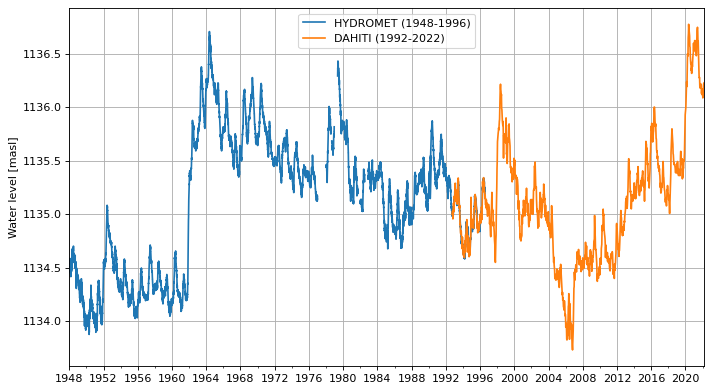

In [123]:
left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(9, 5))
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET (1948-1996)")
DAHITI['water_level'].plot(ax=ax, label="DAHITI (1992-2022)")
ax.grid(True)
ax.legend(loc=9)
plt.xlabel("")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(4))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI_HYDROMET_corr_DH22_19480101_20220303_v3.png'))

In [118]:
data_path

'figures_apr22'

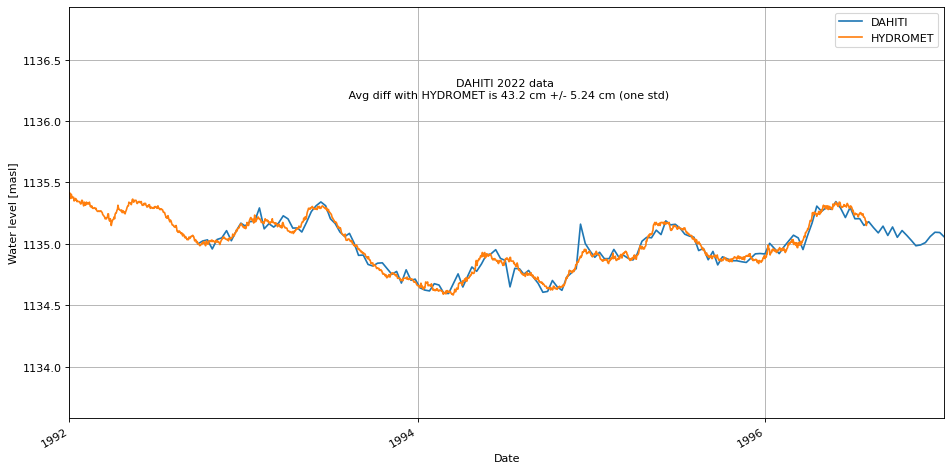

In [55]:
# 2022 data

left = '1992-01-01'
right = '1997-01-10'

fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.text(0.5, 0.8, "DAHITI 2022 data \n Avg diff with HYDROMET is 43.2 cm +/- 5.24 cm (one std)",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

#plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI22_HYDROMET_overlap.png'))

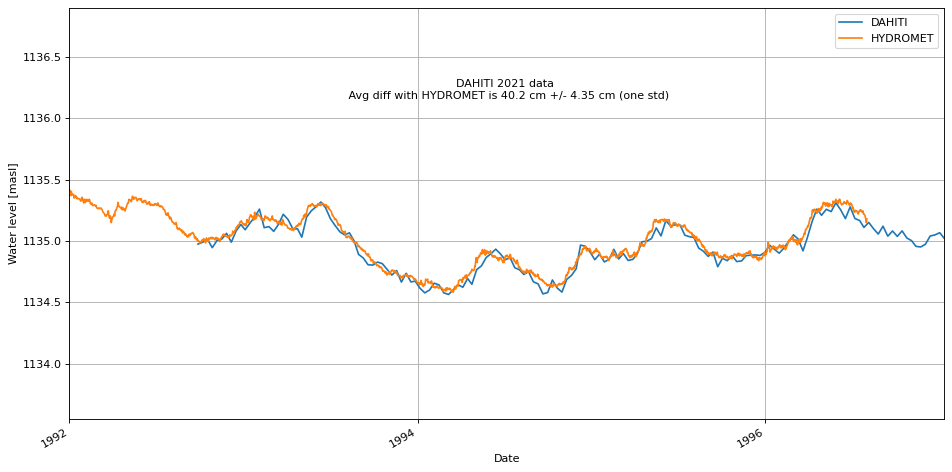

In [56]:
DAHITI_21 = data_2021.copy()
DAHITI_21.rename(columns = {'water level':'water_level'}, inplace = True)

# 2021 DAHITI data - actually it looks better than the 2022 data !!! More similar to Hydromet.. decide whether to maybe use the 2021 data

left = '1992-01-01'
right = '1997-01-10'

fig, ax = plt.subplots(figsize=(12, 6))
DAHITI_21['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
ax.text(0.5, 0.8, "DAHITI 2021 data \n Avg diff with HYDROMET is 40.2 cm +/- 4.35 cm (one std)",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI21_HYDROMET_overlap.png'))

In [57]:
# Hydromet has more than 3 sig figs, round to 3 sig figs 

# 1964 RECORD
# 1964-05-15, 1136.68 masl, 13.39 m in situ

HYDROMET_corr[HYDROMET_corr['water_level']==HYDROMET_corr['water_level'].max()].round(3)

,water_level,meas
date,,
1964-05-15,1136.709,13.39


In [58]:
print('HYDROMET max =',HYDROMET_corr['water_level'].max(), 'HYDROMET max in situ =',HYDROMET_corr['meas'].max() )
geoid_corr = HYDROMET_corr['water_level'].max() - HYDROMET_corr['meas'].max()
print('HYDROMET geoid corr =',geoid_corr)



HYDROMET max = 1136.70900034332 HYDROMET max in situ = 13.3900003433227
HYDROMET geoid corr = 1123.3189999999972


In [59]:
geoid = pd.DataFrame(HYDROMET_corr['water_level'] - HYDROMET_corr['meas'])
geoid.columns = ['geoidcorr']
geoid.geoidcorr.unique()

#str.format('{0:.15f}', geoid.geoidcorr.unique())

# The geoid correction seems pretty much constant 1123.319 meters added to the in situ measurement

array([1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319,      nan])

In [60]:
# 2020 RECORD
# 2020-05-17, 1136.745 masl, 13.455 est in situ

DAHITI[DAHITI['water_level']==DAHITI['water_level'].max()]

,water_level,error
date,,
2020-05-17,1136.777,0.0


In [61]:
print('DAHITI max =', DAHITI['water_level'].max())
print('DAHITI max - HYDROMET max =', DAHITI['water_level'].max() - HYDROMET_corr['water_level'].max())
print('DAHITI est in situ =', DAHITI['water_level'].max() - geoid_corr)
print('DAHITI est in situ (round) =', DAHITI['water_level'].max() - round(geoid_corr,3))

DAHITI max = 1136.777
DAHITI max - HYDROMET max = 0.06799965668005825
DAHITI est in situ = 13.458000000002812
DAHITI est in situ (round) = 13.458000000000084


### Make a single time series from the 2 timeseries

Then do DL/DT and rolling avg L

In [62]:
startHYDROMET = np.datetime64('1948-01-01')
endHYDROMET = np.datetime64('1996-08-01')

startDAHITI = np.datetime64('1992-09-27')
endDAHITI = np.datetime64('2022-03-03') 

HYDROMET_keep = HYDROMET_corr.loc[ startHYDROMET : (startDAHITI - pd.Timedelta("1 day")) ]
HYDROMET_keep = HYDROMET_keep.drop(columns=['meas'])
HYDROMET_keep

# Overwriting time-series with DH where available, check if this is what I want to do or if I 
# would rather keep in situ data as it has higher temporal resolution

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
1992-09-22,1135.034
1992-09-23,1135.024
1992-09-24,1135.009


In [63]:
DAHITI_keep = DAHITI.drop(columns=['error'])
DAHITI_keep

,water_level
date,
1992-09-27,1135.000
1992-10-07,1135.023
1992-10-17,1135.032
1992-10-27,1134.958
1992-11-06,1135.035
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [64]:
df_list = [HYDROMET_keep,DAHITI_keep]
lakelevels_all_raw = pd.concat(df_list, ignore_index=False)
pd.set_option("display.precision", 8)
lakelevels_all_raw

,water_level
date,
1948-01-01,1134.52900004
1948-01-02,1134.53400015
1948-01-03,1134.49400019
1948-01-04,1134.48399996
1948-01-05,1134.50899958
...,...
2022-01-22,1136.14300000
2022-02-01,1136.14500000
2022-02-11,1136.19900000


In [65]:
# Round to 3 sig figs 

lakelevels_all = lakelevels_all_raw.round(3)
pd.set_option("display.precision", 8)
lakelevels_all

# Merge of DAHITI and HYDROMET, with DAHITI overwriting HYDROMET from DAHITI start date (1992-09-27)
# Data gaps from HYDROMET
# Resolution decreases from DAHITI having lower res than HYD
# need to linearly interpolate missing data 

# Save this dataframe to bring it into matlab

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [66]:
meanL = lakelevels_all['water_level'].mean()
maxL = lakelevels_all['water_level'].max()
minL = lakelevels_all['water_level'].min()
mtrim = stats.trim_mean(lakelevels_all[['water_level']], 0.1)
mtrim = mtrim.flatten().tolist()[0]
p10 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 10) # 10th percentile 
p90 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 90) # 90th percentile 

print('meanL =', meanL, 'maxL =', maxL, 'minL =', minL, 'range =', maxL-minL )
print('mtrim =', mtrim, 'p10 =', p10, 'p90 =', p90 )
print('start date =', left, 'enddate =', right)

#meanL = 1135.1319353655604 maxL = 1136.777 minL = 1133.734 range = 3.04300000000012
#mtrim = 1135.1791611953165 p10 = 1134.229 p90 = 1136.104

# Write this stuff to a text file !!!

meanL = 1135.1319353655604 maxL = 1136.777 minL = 1133.734 range = 3.04300000000012
mtrim = 1135.1791611953165 p10 = 1134.229 p90 = 1136.104
start date = 1992-01-01 enddate = 1997-01-10


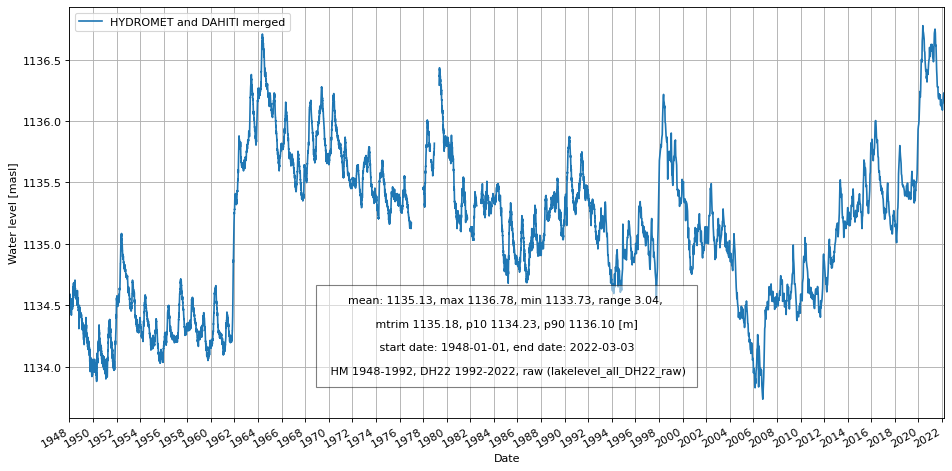

In [67]:
left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
lakelevels_all['water_level'].plot(ax=ax, label="HYDROMET and DAHITI merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, DH22 1992-2022, raw (lakelevel_all_DH22_raw)'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
#plot_text2 = "start date: %s, end date %s years old." %(left, right)
ax.text(0.5, 0.2, (plot_text), # , left, right
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'lakelevel_all_DH22_raw_annotate.png'))

# Merge of DAHITI and HYDROMET, with DAHITI overwriting HYDROMET from DAHITI start date (1992-09-27)
# Data gaps from HYDROMET
# Resolution decreases in overlap period from DAHITI having lower res than HYD

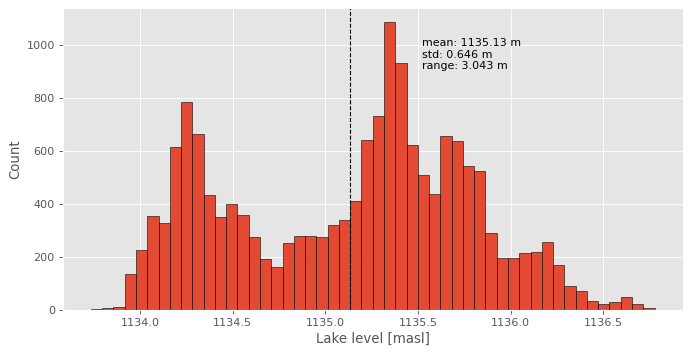

In [68]:
# Histogram of lake levels (it is not a uniform time-series, not interpolated !!)
# Amount of plots
rows = 1
cols = 1
# Style
plt.style.use('ggplot')
#Plot
data = lakelevels_all['water_level']
fig, ax = plt.subplots(figsize=(10, 5 ))
ax.hist(data, bins=50, edgecolor='k')
ax.set_xlabel("Lake level [masl]")
ax.set_ylabel("Count")
min_ylim, max_ylim = plt.ylim()
plot_text = ('mean: {:.2f} m \nstd: {:.3f} m \nrange: {:.3f} m \nstart date: {}, end date: {}'
        .format(round(data.mean(),3), round(data.std(),3), round((data.max()-data.min()),3), left, right ))
plot_text_short = ('mean: {:.2f} m \nstd: {:.3f} m \nrange: {:.3f} m'
        .format(round(data.mean(),3), round(data.std(),3), round((data.max()-data.min()),3)))
ax.text(0.58, 0.9, plot_text_short ,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)
plt.axvline(data.mean(), color='k', linestyle='dashed', linewidth=1)
#plt.tight_layout()
#plt.savefig(os.path.join(data_path,'LL_all_hist_DH22.png'),dpi=300)
plt.style.use('default')


In [69]:
# reset plot settings 

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.rcParams['figure.dpi'] =  80
plt.rcParams['savefig.dpi'] = 300

In [70]:
# Save lake levels merged, not interpolated

lakelevels_all
#lakelevels_all.to_csv(os.path.join('data_modified/lakelevel_all_raw_DH22.csv'),sep=',', index=True, header=True)

# Merged raw time-series not interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)




,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [71]:
# Save as a txt file for import to MATLAB WBM 

lakelevels_all_export = lakelevels_all.copy()
lakelevels_all_export['day'] = lakelevels_all.index.day
lakelevels_all_export['month'] = lakelevels_all.index.month
lakelevels_all_export['year'] = lakelevels_all.index.year
lakelevels_all_export = lakelevels_all_export[['year', 'month', 'day', 'water_level']]
lakelevels_all_export

#lakelevels_all_export.to_csv('data_modified/lakelevel_all_raw_DH22.txt', sep='\t', index=False, header=False)


,year,month,day,water_level
date,,,,
1948-01-01,1948,1,1,1134.529
1948-01-02,1948,1,2,1134.534
1948-01-03,1948,1,3,1134.494
1948-01-04,1948,1,4,1134.484
1948-01-05,1948,1,5,1134.509
...,...,...,...,...
2022-01-22,2022,1,22,1136.143
2022-02-01,2022,2,1,1136.145
2022-02-11,2022,2,11,1136.199


## interpolate to daily resolution

In [72]:
lakelevels_all

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [73]:
# Interpolate to daily res and round to 3 sig figs (number of DAHITI sig figs) - btw I lose the error measurements of Dahiti... 

lakelevels_intr = lakelevels_all.resample('D').asfreq().interpolate(method='linear').round(3)
lakelevels_intr

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-02-27,1136.228
2022-02-28,1136.228
2022-03-01,1136.229


In [74]:
# Export as csv 

#lakelevels_intr.to_csv(os.path.join('data_modified/lakelevel_all_intr_DH22.csv'),sep=',', index=True, header=True)

# Merged time-series interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)



In [75]:
# Export as txt file for matlab 

lakelevels_intr_export = lakelevels_intr.copy()
lakelevels_intr_export['day'] = lakelevels_intr.index.day
lakelevels_intr_export['month'] = lakelevels_intr.index.month
lakelevels_intr_export['year'] = lakelevels_intr.index.year
lakelevels_intr_export = lakelevels_intr_export[['year', 'month', 'day', 'water_level']]
lakelevels_intr_export

#lakelevels_intr_export.to_csv('data_modified/lakelevel_all_intr_DH22.txt', sep='\t', index=False, header=False)

# Merged time-series interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)


,year,month,day,water_level
date,,,,
1948-01-01,1948,1,1,1134.529
1948-01-02,1948,1,2,1134.534
1948-01-03,1948,1,3,1134.494
1948-01-04,1948,1,4,1134.484
1948-01-05,1948,1,5,1134.509
...,...,...,...,...
2022-02-27,2022,2,27,1136.228
2022-02-28,2022,2,28,1136.228
2022-03-01,2022,3,1,1136.229


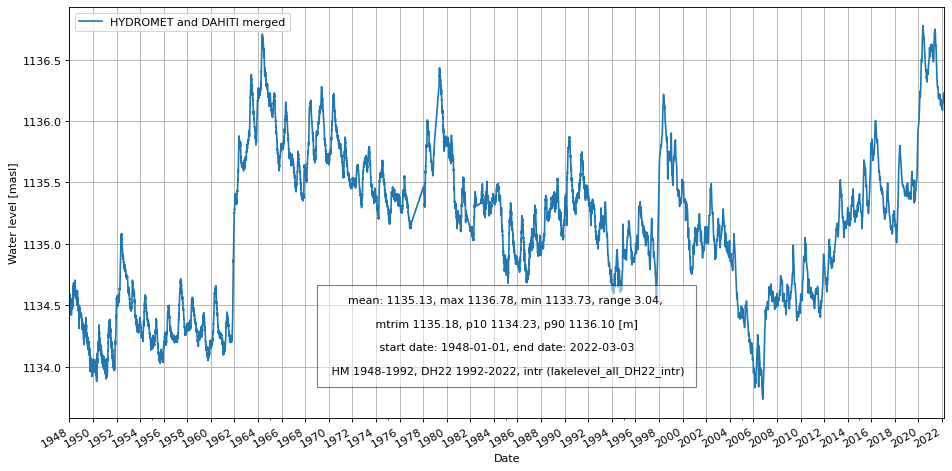

In [76]:
# Plot the interpolated lake levels 



left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
lakelevels_intr['water_level'].plot(ax=ax, label="HYDROMET and DAHITI merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, DH22 1992-2022, intr (lakelevel_all_DH22_intr)'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
ax.text(0.5, 0.2, (plot_text),
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'lakelevel_all_DH22_intr_annotate.png'))


## dL/dt time series for different dt windows 

dt= 720
[Timestamp('1948-01-01 00:00:00'), Timestamp('1949-12-21 00:00:00'), Timestamp('1951-12-11 00:00:00'), Timestamp('1953-11-30 00:00:00'), Timestamp('1955-11-20 00:00:00'), Timestamp('1957-11-09 00:00:00'), Timestamp('1959-10-30 00:00:00'), Timestamp('1961-10-19 00:00:00'), Timestamp('1963-10-09 00:00:00'), Timestamp('1965-09-28 00:00:00'), Timestamp('1967-09-18 00:00:00'), Timestamp('1969-09-07 00:00:00'), Timestamp('1971-08-28 00:00:00'), Timestamp('1973-08-17 00:00:00'), Timestamp('1975-08-07 00:00:00'), Timestamp('1977-07-27 00:00:00'), Timestamp('1979-07-17 00:00:00'), Timestamp('1981-07-06 00:00:00'), Timestamp('1983-06-26 00:00:00'), Timestamp('1985-06-15 00:00:00'), Timestamp('1987-06-05 00:00:00'), Timestamp('1989-05-25 00:00:00'), Timestamp('1991-05-15 00:00:00'), Timestamp('1993-05-04 00:00:00'), Timestamp('1995-04-24 00:00:00'), Timestamp('1997-04-13 00:00:00'), Timestamp('1999-04-03 00:00:00'), Timestamp('2001-03-23 00:00:00'), Timestamp('2003-03-13 00:00:00'), Times

dt= 90
[Timestamp('1948-01-01 00:00:00'), Timestamp('1948-03-31 00:00:00'), Timestamp('1948-06-29 00:00:00'), Timestamp('1948-09-27 00:00:00'), Timestamp('1948-12-26 00:00:00'), Timestamp('1949-03-26 00:00:00'), Timestamp('1949-06-24 00:00:00'), Timestamp('1949-09-22 00:00:00'), Timestamp('1949-12-21 00:00:00'), Timestamp('1950-03-21 00:00:00'), Timestamp('1950-06-19 00:00:00'), Timestamp('1950-09-17 00:00:00'), Timestamp('1950-12-16 00:00:00'), Timestamp('1951-03-16 00:00:00'), Timestamp('1951-06-14 00:00:00'), Timestamp('1951-09-12 00:00:00'), Timestamp('1951-12-11 00:00:00'), Timestamp('1952-03-10 00:00:00'), Timestamp('1952-06-08 00:00:00'), Timestamp('1952-09-06 00:00:00'), Timestamp('1952-12-05 00:00:00'), Timestamp('1953-03-05 00:00:00'), Timestamp('1953-06-03 00:00:00'), Timestamp('1953-09-01 00:00:00'), Timestamp('1953-11-30 00:00:00'), Timestamp('1954-02-28 00:00:00'), Timestamp('1954-05-29 00:00:00'), Timestamp('1954-08-27 00:00:00'), Timestamp('1954-11-25 00:00:00'), Timest

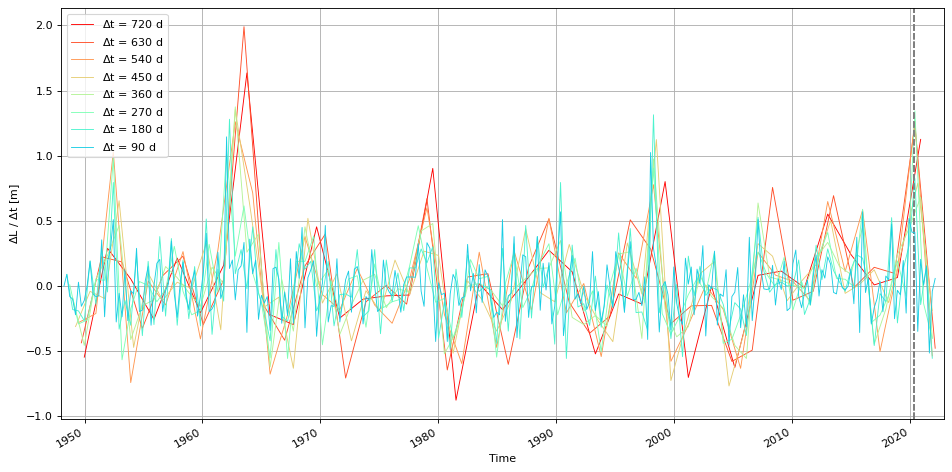

In [97]:
# Settings

startdate = np.datetime64('1948-01-01')
enddate = np.datetime64('2022-03-03') # for loop
eventdate = np.datetime64('2020-05-17')
alldays = pd.date_range(start=startdate,end=enddate) # check this is ok, and why it works even if enddate is may
enddate = np.datetime64('2022-12-01') # for plotting

# Set the color ramp
color = iter(cm.rainbow_r(np.linspace(0, 1, 11))) #rainbow_r

# Make the plot object
fig, ax = plt.subplots(figsize=(12, 6))

# Set the dt in days : 10,15,20...85,90 # from 3 months to 2 years with steps of 3 months
dtstart=90
dtstop=720
dtstep=90
for k in reversed(range(dtstart,(dtstop+dtstep),dtstep)): 
    print('dt=', k)
    c = next(color)
    
    # 1) Make the timeslist 
    dateslist = []
    for i in range(len(alldays)//k + 1 ): # indices 
        #print('k=', k)
        #print('i=', i)
        #print(k*i)
        #print(pd.Timedelta(days=k*i))
        #print(np.datetime64(startdate + pd.Timedelta(days=k*i)))
        date = startdate + pd.Timedelta(days=k*i)
        dateslist.append(date)
    print(dateslist)
    
    # 2) Make the dL 
    dL = []
    for i in range(len(dateslist)-1):
        dL_slice = lakelevels_intr.loc[str(dateslist[i+1])] - lakelevels_intr.loc[str(dateslist[i])]
        dL.append(dL_slice)
    
    # 3) Merge them together in a dataframe 
    df_dL = pd.DataFrame(dL).rename(columns={"water_level": "dL"})
    df_dateslist = pd.DataFrame(dateslist[1:len(dateslist)], columns=['date'])
    df_merge = df_dateslist.merge(df_dL, left_index=True, right_index=True).set_index(['date'])
    df_merge
    
    # 4) Plot 
    plt.axvline(eventdate, color='0.5', linestyle='dashed', linewidth=1.5)
    df_merge['dL'].plot(ax=ax, c=c, label='$\Delta$t = {:.0f} d'.format(k), linewidth=0.8)
    plt.xlabel("Time")
    plt.ylabel("$\Delta$L / $\Delta$t [m]")
    ax.grid(True)
    ax.legend(loc='upper left')
    #ax.set_facecolor('0.6')
    ax.set_xlim(startdate, enddate)

plt.tight_layout()
plt.savefig(os.path.join(data_path,'dLdt_rainbow3.png'),dpi=450)

# Do it for 360 days, print the time-brackets it is being analysed for, 
# save the dL/dt as a function of the time-bracket for each dt 
# Plot the extremity (rank) of the 2020 event

# Try to get this to actually be calendar years? Jan to Jan 

# Make subplots for different DTs to see the different curves better. 

# Maybe plot only certain steps 


## 2) Rolling average L'

In [98]:
lakelevels_all # original data 

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [99]:
lakelevels_intr # interpolated to daily resolution

,water_level
date,
1948-01-01,1134.5290
1948-01-02,1134.5340
1948-01-03,1134.4940
1948-01-04,1134.4840
1948-01-05,1134.5090
...,...
2022-02-27,1136.2282
2022-02-28,1136.2284
2022-03-01,1136.2286


In [100]:
rolling = lakelevels_intr.rolling(10).mean()
rolling

,water_level
date,
1948-01-01,NaN
1948-01-02,NaN
1948-01-03,NaN
1948-01-04,NaN
1948-01-05,NaN
...,...
2022-02-27,1136.22574
2022-02-28,1136.22672
2022-03-01,1136.22744


In [101]:
rolling_filter = rolling.query('water_level == water_level')
rolling_filter 

,water_level
date,
1948-01-10,1134.51800
1948-01-11,1134.52000
1948-01-12,1134.52150
1948-01-13,1134.52500
1948-01-14,1134.52950
...,...
2022-02-27,1136.22574
2022-02-28,1136.22672
2022-03-01,1136.22744


dt= 10
dt= 90
dt= 170
dt= 250
dt= 330
dt= 410
dt= 490
dt= 570
dt= 650
dt= 730


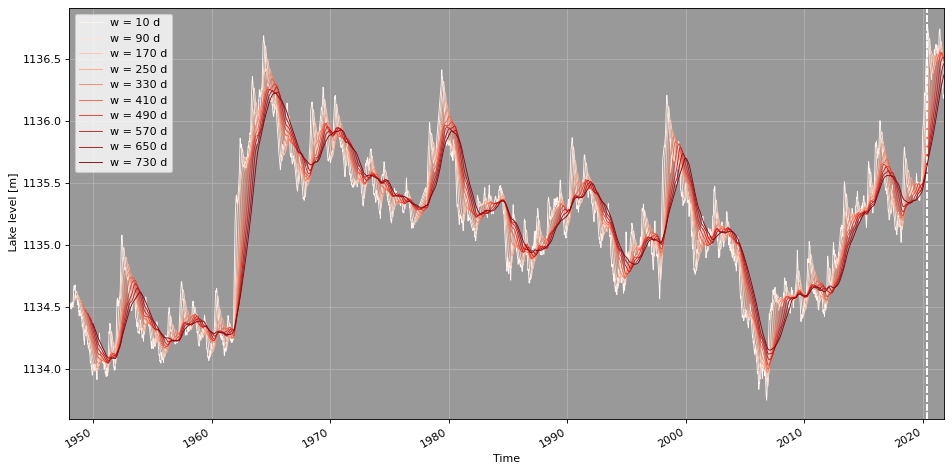

In [102]:
startdate = np.datetime64('1948-01-01')
enddate = np.datetime64('2021-01-10')
enddate = np.datetime64('2021-10-10')

# Set the color ramp
color = iter(cm.Reds(np.linspace(0, 2, 20))) #rainbow_r

# Make the plot object
fig, ax = plt.subplots(figsize=(12, 6))

# Set the dt in days : 10,15,20...85,90
for k in range(10,750,80): 
#for k in range(10,380,40):
    print('dt=', k)
    c = next(color)
    
    # Get rolling mean and filter out NaN
    data = lakelevels_intr.rolling(k).mean()
    data_filter = data.query('water_level == water_level')
    
    # Plot 
    plt.axvline(eventdate, color='1', linestyle='dashed', linewidth=1.5)
    data_filter['water_level'].plot(ax=ax, c=c, label='w = {:.0f} d'.format(k), linewidth=0.8)
    plt.xlabel("Time")
    plt.ylabel(" Lake level [m]")
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_facecolor('0.6')
    ax.set_xlim(startdate, enddate)

    plt.tight_layout()
#plt.savefig(os.path.join(data_path,'rollingavg_2yr_4.png'),dpi=450)

# extensions:

# fix artefact of it moving forward (set it to start date)
# take averaging window at which it stops being record-breaking, if it's 30 days or 90 days 
# this is OK - check window for which we have record-breaking event 
# See if you can correlate both curves to an index, +IOD, teleconnections 